# Word Pronunciation Example Using SageMaker (AWS-SDK) Seq2Seq

1. [Introduction](#Introduction)
2. [Setup](#Setup)
3. [Download dataset and preprocess](#Download-dataset-and-preprocess)
3. [Training the Word Pronunciation model](#Training-the-Word-Pronunciation-model)
4. [Inference](#Inference)

## Introduction

Welcome to our Word Pronunciation end-to-end example! In this demo, we will train an English Word Pronunciation model and will test the predictions on a few examples.

SageMaker Seq2Seq algorithm is built on top of [Sockeye](https://github.com/awslabs/sockeye), a sequence-to-sequence framework for Neural Machine Translation based on MXNet. SageMaker Seq2Seq implements state-of-the-art encoder-decoder architectures which can also be used for tasks like Abstractive Summarization.

SageMaker notebook has already provided you a sample Seq2seq that help you to build an English-Germany machine translation model based on a language data provided by [the Machine Translation Group at UEDIN](http://data.statmt.org/wmt17/translation-task/preprocessed/) (e.g. sample-notebooks/introduction_to_amazon_algorithms/seq2seq_translation_en-de). In this example, we are going to use Word-Pronunciation dataset provided by [CMUSphinx](https://cmusphinx.github.io/). 

To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on.

## Setup

Let's start by specifying:
- The S3 bucket and prefix that you want to use for training and model data. **This should be within the same region as the Notebook Instance, training, and hosting.**
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp in the cell below with a the appropriate full IAM role arn string(s).

In [69]:
# S3 bucket and prefix
bucket = '<your_s3_bucket_name_here>'
prefix = 'seq2seq/word-pronunciation'  
# i.e.'<your_s3_bucket>/seq2seq/word-pronunciation'

In [70]:
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

Next, we'll import the Python libraries we'll need for the remainder of the exercise.

In [71]:
from time import gmtime, strftime
import time
import numpy as np
import os
import json
import random

# For plotting attention matrix later on
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

## Download dataset and preprocess

The most of the preprocessing script is borrowed from 
https://github.com/sunilmallya/dl-twitch-series/blob/master/E2_word_pronounciations.ipynb

In this notebook, we will train a word-pronunciation model on a dataset from the
[CMUdict  --  Major Version: 0.07](http://svn.code.sf.net/p/cmusphinx/code/trunk/cmudict/cmudict-0.7b).

In [72]:
import urllib

def download_data(url, force_download=True): 
    fname = url.split("/")[-1]
    if force_download or not os.path.exists(fname):
        urllib.request.urlretrieve(url, fname)
    return fname

url_ds1 = "http://svn.code.sf.net/p/cmusphinx/code/trunk/cmudict/cmudict-0.7b"
fname = download_data(url_ds1) 
print(fname)

cmudict-0.7b


In [68]:
#!wget http://svn.code.sf.net/p/cmusphinx/code/trunk/cmudict/cmudict-0.7b

--2018-02-15 23:18:07--  http://svn.code.sf.net/p/cmusphinx/code/trunk/cmudict/cmudict-0.7b
Resolving svn.code.sf.net (svn.code.sf.net)... 216.34.181.157
Connecting to svn.code.sf.net (svn.code.sf.net)|216.34.181.157|:80... failed: Connection refused.


In [5]:
# Load data
data = open(fname, mode = 'rt', encoding = "ISO-8859-1")

In [6]:
# Generate words list and phones list
words = []
phones = []

def f_char(word):
    for c in ["(", ".", "'", ")", "-", "_", "\xc0", "\xc9", ';']: ### added ;
        #print c in word, type(word)
        if c in word:
            return True
    return False

i_count = 0

for d in data:
    parts = d.strip('\n').split('  ') 
    #print(i_count)
    #i_count += 1
    #if not f_char(parts[0]):
    if re.match('^[A-Z]', parts[0]) and not f_char(parts[0]):
        words.append(parts[0])
        phones.append(parts[1])

Let's take a look at a word-phoneme pair. 

In [7]:
idx = 648
print(words[idx])
print(phones[idx])

ACKNOWLEDGEMENT
AE0 K N AA1 L IH0 JH M AH0 N T


In [8]:
len(words), len(phones)

(116519, 116519)

Here is the set of charactors in the entire dataset. 

In [9]:
all_chars = set()
for word, phone in zip(words, phones):
    for c in word:
        all_chars.add(c)
    for p in phone.split(" "):
        all_chars.add(p)
        
print(all_chars)
print(len(all_chars))

{'Q', 'ZH', 'AW2', 'ER1', 'DH', '0', 'EH0', 'OY2', 'U', 'IH0', 'UH0', 'UW1', 'EY2', 'F', 'AO0', 'V', 'AY1', 'G', 'I', 'O', 'EY0', 'OW1', 'X', '9', 'AA1', '8', 'EH1', 'Z', 'J', 'CH', 'M', 'E', 'IY0', 'P', '5', 'H', 'D', 'A', 'TH', 'AO2', '6', '4', 'UH2', 'AE1', 'OW2', 'AH0', 'ER0', '7', 'AH1', 'AA2', 'SH', 'JH', 'IY2', 'AA0', 'R', 'UH1', 'AY2', 'UW2', 'IY1', 'IH1', 'OY0', 'AH2', 'B', '1', 'T', 'IH2', '3', 'AW0', 'OY1', 'AW1', 'N', 'S', 'AO1', 'EY1', 'C', 'AE2', 'HH', 'W', 'AE0', 'UW0', 'EH2', 'OW0', 'K', '2', 'L', 'AY0', 'Y', 'NG', 'ER2'}
89


### Lets define some helper functions to convert words to symbols and vice versa

In [10]:
# Create a map of symbols to numbers
symbol_set = sorted(list(all_chars))

# word to symbol index
def word_to_symbol_index(word):
    return [symbol_set.index(char) for char in word]

# list of symbol index to word
def symbol_index_to_word(indices):
    return [symbol_set[idx] for idx in indices]

# phone to symbol index
def phone_to_symbol_index(phone):
    return [symbol_set.index(p) for p in phone.split(" ")]

# list of symbol index to word
def psymbol_index_to_word(indices):
    return [symbol_set[idx] for idx in indices]

print(symbol_set)
print(len(symbol_set))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'AA0', 'AA1', 'AA2', 'AE0', 'AE1', 'AE2', 'AH0', 'AH1', 'AH2', 'AO0', 'AO1', 'AO2', 'AW0', 'AW1', 'AW2', 'AY0', 'AY1', 'AY2', 'B', 'C', 'CH', 'D', 'DH', 'E', 'EH0', 'EH1', 'EH2', 'ER0', 'ER1', 'ER2', 'EY0', 'EY1', 'EY2', 'F', 'G', 'H', 'HH', 'I', 'IH0', 'IH1', 'IH2', 'IY0', 'IY1', 'IY2', 'J', 'JH', 'K', 'L', 'M', 'N', 'NG', 'O', 'OW0', 'OW1', 'OW2', 'OY0', 'OY1', 'OY2', 'P', 'Q', 'R', 'S', 'SH', 'T', 'TH', 'U', 'UH0', 'UH1', 'UH2', 'UW0', 'UW1', 'UW2', 'V', 'W', 'X', 'Y', 'Z', 'ZH']
89


Tokenize words

In [11]:
# sample word
idx = 648
indices_word = word_to_symbol_index(words[idx])
print(indices_word, symbol_index_to_word(indices_word))

[10, 30, 57, 60, 62, 84, 58, 34, 32, 45, 34, 59, 34, 60, 74] ['A', 'C', 'K', 'N', 'O', 'W', 'L', 'E', 'D', 'G', 'E', 'M', 'E', 'N', 'T']


Tokenize phonemes

In [12]:
# sample phone
indices_phone = phone_to_symbol_index(phones[idx])
print(indices_phone, symbol_index_to_word(indices_phone))

[14, 57, 60, 12, 58, 49, 56, 59, 17, 60, 74] ['AE0', 'K', 'N', 'AA1', 'L', 'IH0', 'JH', 'M', 'AH0', 'N', 'T']


For any RNN task, it is important to keep track of the maximum length of input/output sequence. 

In [13]:
# max_length
source_sequence_length = max([len(w) for w in words])
target_sequence_length = max([len(p.split(' ')) for p in phones])

max_length = max(source_sequence_length, target_sequence_length)
print(source_sequence_length, target_sequence_length, max_length)

34 32 34


Let's put together source data. 

In [14]:
### Source: Words
dataX = []
for word in words:
    dataX.append(np.array(word_to_symbol_index(word)))

In [15]:
idx = 648
dataX[idx], symbol_index_to_word(dataX[idx])

(array([10, 30, 57, 60, 62, 84, 58, 34, 32, 45, 34, 59, 34, 60, 74]),
 ['A', 'C', 'K', 'N', 'O', 'W', 'L', 'E', 'D', 'G', 'E', 'M', 'E', 'N', 'T'])

Let's put together target data as well. 

In [16]:
### Target: Phonemes
dataY =[]
for p in phones:
    dataY.append(np.array(phone_to_symbol_index(p)))

In [17]:
idx = 648
dataY[idx], symbol_index_to_word(dataY[idx])

(array([14, 57, 60, 12, 58, 49, 56, 59, 17, 60, 74]),
 ['AE0', 'K', 'N', 'AA1', 'L', 'IH0', 'JH', 'M', 'AH0', 'N', 'T'])

In [18]:
len(dataY), len(dataX)

(116519, 116519)

In [19]:
idx = 648

print("SRC: ", symbol_index_to_word(dataX[idx]))
print("TRG: ", symbol_index_to_word(dataY[idx])) 
print("SRC: ", dataX[idx])
print("TRG: ", dataY[idx])

SRC:  ['A', 'C', 'K', 'N', 'O', 'W', 'L', 'E', 'D', 'G', 'E', 'M', 'E', 'N', 'T']
TRG:  ['AE0', 'K', 'N', 'AA1', 'L', 'IH0', 'JH', 'M', 'AH0', 'N', 'T']
SRC:  [10 30 57 60 62 84 58 34 32 45 34 59 34 60 74]
TRG:  [14 57 60 12 58 49 56 59 17 60 74]


In [20]:
### Train Validation Split ###

def shuffle_together(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

dataX, dataY = np.array(dataX), np.array(dataY)
dataX, dataY = shuffle_together(dataX, dataY)

print(dataX[:3])
print(dataY[:3])

print(dataX[:3] + 4)
print(dataY[:3] + 4)

N = int(len(dataX) * 0.9) # 90%

### First 4 indices are saved for special characters ###

trainX = dataX[:N] + 4
trainY = dataY[:N] + 4

print(dataX[:3])
print(dataY[:3])
print(trainX[:3])
print(trainY[:3])

valX = dataX[N:] + 4
valY = dataY[N:] + 4

print(dataX[:3])
print(dataY[:3])

print(type(trainX), type(trainX[0].tolist()), type(trainX[0].tolist()[0]))
print(type(trainY), type(trainY[0].tolist()), type(trainX[0].tolist()[0]))

[array([59, 76, 71, 57, 62, 84, 72, 57, 48])
 array([44, 48, 58, 30, 46, 34, 32])
 array([69, 58, 10, 74, 34, 58, 34, 74])]
[array([59, 38, 57, 24, 72, 57, 52]) array([44, 50, 58, 31, 74])
 array([69, 58, 42, 74, 58, 17, 74])]
[array([63, 80, 75, 61, 66, 88, 76, 61, 52])
 array([48, 52, 62, 34, 50, 38, 36])
 array([73, 62, 14, 78, 38, 62, 38, 78])]
[array([63, 42, 61, 28, 76, 61, 56]) array([48, 54, 62, 35, 78])
 array([73, 62, 46, 78, 62, 21, 78])]
[array([59, 76, 71, 57, 62, 84, 72, 57, 48])
 array([44, 48, 58, 30, 46, 34, 32])
 array([69, 58, 10, 74, 34, 58, 34, 74])]
[array([59, 38, 57, 24, 72, 57, 52]) array([44, 50, 58, 31, 74])
 array([69, 58, 42, 74, 58, 17, 74])]
[array([63, 80, 75, 61, 66, 88, 76, 61, 52])
 array([48, 52, 62, 34, 50, 38, 36])
 array([73, 62, 14, 78, 38, 62, 38, 78])]
[array([63, 42, 61, 28, 76, 61, 56]) array([48, 54, 62, 35, 78])
 array([73, 62, 46, 78, 62, 21, 78])]
[array([59, 76, 71, 57, 62, 84, 72, 57, 48])
 array([44, 48, 58, 30, 46, 34, 32])
 array([69

### Generate vocabulary json files.

Amazon SageMaker seq2seq requires two json "vocabulary" files. 

In [21]:
### First 4 indices are saved for special characters ###
vocab_dict = {c:i + 4 for i,c in enumerate(symbol_set)}
vocab_dict

{'0': 4,
 '1': 5,
 '2': 6,
 '3': 7,
 '4': 8,
 '5': 9,
 '6': 10,
 '7': 11,
 '8': 12,
 '9': 13,
 'A': 14,
 'AA0': 15,
 'AA1': 16,
 'AA2': 17,
 'AE0': 18,
 'AE1': 19,
 'AE2': 20,
 'AH0': 21,
 'AH1': 22,
 'AH2': 23,
 'AO0': 24,
 'AO1': 25,
 'AO2': 26,
 'AW0': 27,
 'AW1': 28,
 'AW2': 29,
 'AY0': 30,
 'AY1': 31,
 'AY2': 32,
 'B': 33,
 'C': 34,
 'CH': 35,
 'D': 36,
 'DH': 37,
 'E': 38,
 'EH0': 39,
 'EH1': 40,
 'EH2': 41,
 'ER0': 42,
 'ER1': 43,
 'ER2': 44,
 'EY0': 45,
 'EY1': 46,
 'EY2': 47,
 'F': 48,
 'G': 49,
 'H': 50,
 'HH': 51,
 'I': 52,
 'IH0': 53,
 'IH1': 54,
 'IH2': 55,
 'IY0': 56,
 'IY1': 57,
 'IY2': 58,
 'J': 59,
 'JH': 60,
 'K': 61,
 'L': 62,
 'M': 63,
 'N': 64,
 'NG': 65,
 'O': 66,
 'OW0': 67,
 'OW1': 68,
 'OW2': 69,
 'OY0': 70,
 'OY1': 71,
 'OY2': 72,
 'P': 73,
 'Q': 74,
 'R': 75,
 'S': 76,
 'SH': 77,
 'T': 78,
 'TH': 79,
 'U': 80,
 'UH0': 81,
 'UH1': 82,
 'UH2': 83,
 'UW0': 84,
 'UW1': 85,
 'UW2': 86,
 'V': 87,
 'W': 88,
 'X': 89,
 'Y': 90,
 'Z': 91,
 'ZH': 92}

Add 4 special characters. 

In [22]:
PAD_SYMBOL = "<pad>" #0
UNK_SYMBOL = "<unk>" #1
BOS_SYMBOL = "<s>" #2
EOS_SYMBOL = "</s>" #3

VOCAB_SYMBOLS = [PAD_SYMBOL, UNK_SYMBOL, BOS_SYMBOL, EOS_SYMBOL]
vocab_dict[PAD_SYMBOL] = 0
vocab_dict[UNK_SYMBOL] = 1
vocab_dict[BOS_SYMBOL] = 2
vocab_dict[EOS_SYMBOL] = 3
vocab_dict

{'0': 4,
 '1': 5,
 '2': 6,
 '3': 7,
 '4': 8,
 '5': 9,
 '6': 10,
 '7': 11,
 '8': 12,
 '9': 13,
 '</s>': 3,
 '<pad>': 0,
 '<s>': 2,
 '<unk>': 1,
 'A': 14,
 'AA0': 15,
 'AA1': 16,
 'AA2': 17,
 'AE0': 18,
 'AE1': 19,
 'AE2': 20,
 'AH0': 21,
 'AH1': 22,
 'AH2': 23,
 'AO0': 24,
 'AO1': 25,
 'AO2': 26,
 'AW0': 27,
 'AW1': 28,
 'AW2': 29,
 'AY0': 30,
 'AY1': 31,
 'AY2': 32,
 'B': 33,
 'C': 34,
 'CH': 35,
 'D': 36,
 'DH': 37,
 'E': 38,
 'EH0': 39,
 'EH1': 40,
 'EH2': 41,
 'ER0': 42,
 'ER1': 43,
 'ER2': 44,
 'EY0': 45,
 'EY1': 46,
 'EY2': 47,
 'F': 48,
 'G': 49,
 'H': 50,
 'HH': 51,
 'I': 52,
 'IH0': 53,
 'IH1': 54,
 'IH2': 55,
 'IY0': 56,
 'IY1': 57,
 'IY2': 58,
 'J': 59,
 'JH': 60,
 'K': 61,
 'L': 62,
 'M': 63,
 'N': 64,
 'NG': 65,
 'O': 66,
 'OW0': 67,
 'OW1': 68,
 'OW2': 69,
 'OY0': 70,
 'OY1': 71,
 'OY2': 72,
 'P': 73,
 'Q': 74,
 'R': 75,
 'S': 76,
 'SH': 77,
 'T': 78,
 'TH': 79,
 'U': 80,
 'UH0': 81,
 'UH1': 82,
 'UH2': 83,
 'UW0': 84,
 'UW1': 85,
 'UW2': 86,
 'V': 87,
 'W': 88,
 'X': 89,


In this example, source and target data share the same vocabulary dataset. 

In [23]:
import json
with open('vocab.src.json', 'w') as fp:
    json.dump(vocab_dict, fp, indent=4, ensure_ascii=False)
        
with open('vocab.trg.json', 'w') as fp:
    json.dump(vocab_dict, fp, indent=4, ensure_ascii=False)

### Generate recordio-protobuf files.

Amazon SageMaker expects data in the recordio-protobuf format (e.g. train.rec and val.rec). The function ``write_to_file`` generates a recordio-protobuf file from a stack of sequences using several helper functions from ``create_vocab_proto.py`` and ``record_pb2.py``.  

In [24]:
import multiprocessing 
import logging

from typing import List 
from record_pb2 import Record ### record_pb2.py
from create_vocab_proto import write_worker, write_recordio, list_to_record_bytes, read_worker
import struct
import io

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

            
def write_to_file(np_dataX, np_dataY, file_type, output_file):
    num_read_workers = max(multiprocessing.cpu_count() - 1, 1) 
    logger.info('Spawning %s encoding worker(s) for encoding %s datasets!', str(num_read_workers), file_type) 
    
    q_in = [multiprocessing.Queue() for i in range(num_read_workers)] 
 
    q_out = multiprocessing.Queue() 

    read_process = [multiprocessing.Process(target=read_worker,
                    args=(q_in[i], q_out)) for i in range(num_read_workers)] 
   
    for p in read_process: 
        p.start()

    write_process = multiprocessing.Process(target=write_worker, args=(q_out, output_file)) 
    write_process.start() 
    
    lines_ignored = 0 # No ignored lines in this example. 
    lines_processed = 0
    
    for i, int_source  in enumerate(np_dataX):
        int_source = int_source.tolist()
        int_target = np_dataY[i].tolist()
        item = (int_source, int_target) ### <class 'list'>, <class 'list'>

        if random.random() < 0.0001:
            ### Print some SRC-TRG pairs. 
            print('===   ===   ===   ===   ===')
            print('SRC:', int_source)
            print(len(int_source), type(int_source), type(int_source[0])) # num <class 'list'> <class 'int'>
            print('---   ---   ---   ---   ---')
            print('TRG:', int_target)
            print(len(int_target), type(int_target), type(int_target[0])) # num <class 'list'> <class 'int'>

        q_in[lines_processed % len(q_in)].put(item) 

        lines_processed += 1 
    
    logger.info("""Processed %s lines for encoding to protobuf. %s lines were ignored as they didn't have
                any content in either the source or the target file!""", lines_processed, lines_ignored)
    
    logger.info('Completed writing the encoding queue!')

    for q in q_in: 
        q.put(None) 
    for p in read_process: 
        p.join()
    logger.info('Encoding finished! Writing records to "%s"', output_file)
    q_out.put(None) 
    write_process.join() 
    logger.info('Processed input and saved to "%s"', output_file)
    print('+++---+++---+++---+++---+++')

Training Data

In [25]:
file_type = 'train'
output_file = "train.rec"
write_to_file(trainX, trainY, file_type, output_file)

===   ===   ===   ===   ===
SRC: [63, 38, 52, 76, 64, 38, 75]
7 <class 'list'> <class 'int'>
---   ---   ---   ---   ---
TRG: [63, 31, 76, 64, 42]
5 <class 'list'> <class 'int'>
===   ===   ===   ===   ===
SRC: [38, 78, 50, 64, 52, 34, 52, 78, 90]
9 <class 'list'> <class 'int'>
---   ---   ---   ---   ---
TRG: [39, 79, 64, 54, 76, 53, 78, 56]
8 <class 'list'> <class 'int'>
===   ===   ===   ===   ===
SRC: [76, 33, 14, 75, 75, 66]
6 <class 'list'> <class 'int'>
---   ---   ---   ---   ---
TRG: [76, 33, 16, 75, 67]
5 <class 'list'> <class 'int'>
===   ===   ===   ===   ===
SRC: [33, 38, 36, 64, 66, 75, 91]
7 <class 'list'> <class 'int'>
---   ---   ---   ---   ---
TRG: [33, 40, 36, 64, 24, 75, 91]
7 <class 'list'> <class 'int'>
===   ===   ===   ===   ===
SRC: [34, 75, 66, 88, 64, 62, 52, 61, 38]
9 <class 'list'> <class 'int'>
---   ---   ---   ---   ---
TRG: [61, 75, 28, 64, 62, 32, 61]
7 <class 'list'> <class 'int'>
===   ===   ===   ===   ===
SRC: [78, 75, 14, 34, 61]
5 <class 'list'>

Validation Data

In [26]:
file_type = 'validation'
output_file = "val.rec"
write_to_file(valX, valY, file_type, output_file)

===   ===   ===   ===   ===
SRC: [76, 66, 75, 78, 66, 75]
6 <class 'list'> <class 'int'>
---   ---   ---   ---   ---
TRG: [76, 25, 75, 78, 42]
5 <class 'list'> <class 'int'>
+++---+++---+++---+++---+++


### Upload the files to S3

So far we have the following 4 files. 
- train.rec : Contains source and target sequences for training in protobuf format
- val.rec : Contains source and target sequences for validation in protobuf format
- vocab.src.json : Vocabulary mapping (string to int) for source 
- vocab.trg.json : Vocabulary mapping (string to int) for target 

Let's upload the pre-processed dataset and vocabularies to S3

In [27]:
def upload_to_s3(bucket, prefix, channel, file):
    s3 = boto3.resource('s3')
    data = open(file, "rb")
    key = prefix + "/" + channel + '/' + file
    s3.Bucket(bucket).put_object(Key=key, Body=data)

upload_to_s3(bucket, prefix, 'train', 'train.rec') 
#/<your s3 bucket>/seq2seq/word-pronunciation/train/train.rec
upload_to_s3(bucket, prefix, 'validation', 'val.rec') 
#/<your s3 bucket>/seq2seq/word-pronunciation/validation/val.rec 
upload_to_s3(bucket, prefix, 'vocab', 'vocab.src.json') 
#/<your s3 bucket>/seq2seq/word-pronunciation/vocab/vocab.src.json
upload_to_s3(bucket, prefix, 'vocab', 'vocab.trg.json') 
#/<your s3 bucket>/seq2seq/word-pronunciation/vocab/vocab.trg.json

Those files are uploaded to S3. 

In [28]:
region_name = boto3.Session().region_name

### Container

This is where the magic happens. 

In [29]:
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/seq2seq:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/seq2seq:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/seq2seq:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/seq2seq:latest'}
container = containers[region_name]
print('Using SageMaker Seq2Seq container: {} ({})'.format(container, region_name))

Using SageMaker Seq2Seq container: 811284229777.dkr.ecr.us-east-1.amazonaws.com/seq2seq:latest (us-east-1)


## Training the Word Pronunciation model

In [30]:
job_name = 'seq2seq-wrd-phn-p2-xlarge-' + strftime("%Y-%m-%d-%H-%M", gmtime())
print("Training job", job_name)

create_training_params = \
{
    "AlgorithmSpecification": {
        "TrainingImage": container,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": "s3://{}/{}/".format(bucket, prefix)
    },
    "ResourceConfig": {
        # Seq2Seq does not support multiple machines. Currently, it only supports single machine, multiple GPUs
        "InstanceCount": 1,
        "InstanceType": "ml.p2.xlarge", # We suggest one of ["ml.p2.16xlarge", "ml.p2.8xlarge", "ml.p2.xlarge"]
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        # Please refer to the documentation for complete list of parameters
        "max_seq_len_source": str(source_sequence_length),
        "max_seq_len_target": str(target_sequence_length),
        "optimized_metric": "bleu", 
        "batch_size": "64", # Please use a larger batch size (256 or 512) if using ml.p2.8xlarge or ml.p2.16xlarge
        "checkpoint_frequency_num_batches": "1000",
        "rnn_num_hidden": "512",
        "num_layers_encoder": "1",
        "num_layers_decoder": "1",
        "num_embed_source": "512",
        "num_embed_target": "512",
        "checkpoint_threshold": "3",
        #"max_num_batches": "2100"
        # Training will stop after 2100 iterations/batches.
        # This is just for demo purposes. Remove the above parameter if you want a better model.
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 48 * 3600
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/train/".format(bucket, prefix),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
        },
        {
            "ChannelName": "vocab",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/vocab/".format(bucket, prefix),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/validation/".format(bucket, prefix),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
        }
    ]
}

sagemaker_client = boto3.Session().client(service_name='sagemaker')
sagemaker_client.create_training_job(**create_training_params)

status = sagemaker_client.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print(status)

Training job seq2seq-wrd-phn-p2-xlarge-2018-02-14-17-47
InProgress


In [38]:
### Please keep on checking the status until this says "Completed". ###

status = sagemaker_client.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print(status)
# if the job failed, determine why
if status == 'Failed':
    message = sagemaker_client.describe_training_job(TrainingJobName=job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))
    raise Exception('Training job failed')

Completed


> Now wait for the training job to **complete** and proceed to the next step after you see model artifacts in your S3 bucket.
> If the cell above this returns **InProgress**, you still have to wait. 

+++---+++---+++---+++---+++---+++---+++---+++---+++---+++---+++---+++---+++---+++---+++---+++---+++---+++---+++---+++

## Inference

A trained model does nothing on its own. We now want to use the model to perform inference. For this example, that means pronouncing word(s).
This section involves several steps,
- Create model - Create a model using the artifact (model.tar.gz) produced by training
- Create Endpoint Configuration - Create a configuration defining an endpoint, using the above model
- Create Endpoint - Use the configuration to create an inference endpoint.
- Perform Inference - Perform inference on some input data using the endpoint.

### Create model
We now create a SageMaker Model from the training output. Using the model, we can then create an Endpoint Configuration.

In [39]:
%%time

sage = boto3.client('sagemaker')

info = sage.describe_training_job(TrainingJobName=job_name)
model_name=job_name
model_data = info['ModelArtifacts']['S3ModelArtifacts']

print(model_name)
print(model_data)

primary_container = {
    'Image': container,
    'ModelDataUrl': model_data
}

create_model_response = sage.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

seq2seq-wrd-phn-p2-xlarge-2018-02-14-17-47
s3://use-nv-sagemaker/seq2seq/word-pronunciation/seq2seq-wrd-phn-p2-xlarge-2018-02-14-17-47/output/model.tar.gz
arn:aws:sagemaker:us-east-1:148886336128:model/seq2seq-wrd-phn-p2-xlarge-2018-02-14-17-47
CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 344 ms


### Create endpoint configuration
Use the model to create an endpoint configuration. The endpoint configuration also contains information about the type and number of EC2 instances to use when hosting the model.

Since SageMaker Seq2Seq is based on Neural Nets, we could use an ml.p2.xlarge (GPU) instance, but for this example we will use a free tier eligible ml.m4.xlarge.

In [40]:
from time import gmtime, strftime

endpoint_config_name = 'Seq2SeqEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = sage.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge', #####
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

Seq2SeqEndpointConfig-2018-02-14-20-20-44
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:148886336128:endpoint-config/seq2seqendpointconfig-2018-02-14-20-20-44


### Create endpoint
Lastly, we create the endpoint that serves up model, through specifying the name and configuration defined above. The end result is an endpoint that can be validated and incorporated into production applications. This takes 10-15 minutes to complete.

In [41]:
%%time
import time

endpoint_name = 'Seq2SeqEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = sage.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = sage.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

# wait until the status has changed
sage.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)

# print the status of the endpoint
endpoint_response = sage.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
print('Endpoint creation ended with EndpointStatus = {}'.format(status))

if status != 'InService':
    raise Exception('Endpoint creation failed.')

Seq2SeqEndpoint-2018-02-14-20-21-09
arn:aws:sagemaker:us-east-1:148886336128:endpoint/seq2seqendpoint-2018-02-14-20-21-09
Status: Creating
Endpoint creation ended with EndpointStatus = InService
CPU times: user 112 ms, sys: 8 ms, total: 120 ms
Wall time: 10min 33s


If you see the message,
> Endpoint creation ended with EndpointStatus = InService

then congratulations! You now have a functioning inference endpoint. You can confirm the endpoint configuration and status by navigating to the "Endpoints" tab in the AWS SageMaker console.  

We will finally create a runtime object from which we can invoke the endpoint.

In [42]:
runtime = boto3.client(service_name='runtime.sagemaker') 

# Perform Inference

### Using JSON format for inference (Suggested for a single or small number of data instances)

#### Note that you don't have to convert string to text using the vocabulary mapping for inference using JSON mode

In [43]:
# Making an input: " ".join(list(word.upper())) 
word_infr = 'abcdefg'
print(" ".join(list(word_infr.upper())))

A B C D E F G


In [44]:
words_infr = ["car",
        "cat",
        "tapeworm",
        "tapdance",
        "supercalifragilistic",
        "expialidocious"]

payload = {"instances" : []}
for word_infr in words_infr:
    
    payload["instances"].append({"data" : " ".join(list(word_infr.upper()))})

response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/json', 
                                   Body=json.dumps(payload))

response = response["Body"].read().decode("utf-8")
response = json.loads(response)
print(response)

{'predictions': [{'target': 'K AA1 R'}, {'target': 'K AE1 T'}, {'target': 'T EY1 P W ER2 M'}, {'target': 'T AE1 P D AH0 N S'}, {'target': 'S UW2 P ER0 K AE2 L AH0 F R AE1 JH AH0 L IH2 S T IH0 K'}, {'target': 'EH2 K S P IY0 AE2 L AH0 D OW1 SH AH0 S'}]}


### Retrieving the Attention Matrix

Passing `"attention_matrix":"true"` in `configuration` of the data instance will return the attention matrix.

In [45]:
word_infr = 'height'

payload = {"instances" : [{
                            "data" : " ".join(list(word_infr.upper())),
                            "configuration" : {"attention_matrix":"true"}
                          }
                         ]}

response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/json', 
                                   Body=json.dumps(payload))

response = response["Body"].read().decode("utf-8")
response = json.loads(response)['predictions'][0]

source = " ".join(list(word_infr.upper()))
target = response["target"]
attention_matrix = np.array(response["matrix"])

print("Source: %s \nTarget: %s" % (source, target))

Source: H E I G H T 
Target: HH AY1 T


In [46]:
# Define a function for plotting the attentioan matrix
def plot_matrix(attention_matrix, target, source):
    source_tokens = source.split()
    target_tokens = target.split()
    assert attention_matrix.shape[0] == len(target_tokens)
    plt.imshow(attention_matrix.transpose(), interpolation="nearest", cmap="Greys")
    plt.xlabel("target")
    plt.ylabel("source")
    plt.gca().set_xticks([i for i in range(0, len(target_tokens))])
    plt.gca().set_yticks([i for i in range(0, len(source_tokens))])
    plt.gca().set_xticklabels(target_tokens)
    plt.gca().set_yticklabels(source_tokens)
    plt.tight_layout()

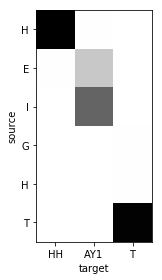

In [47]:
plot_matrix(attention_matrix, target, source)

### Using Protobuf format for inference (Suggested for efficient bulk inference)

Reading the vocabulary mappings as this mode of inference accepts list of integers and returns list of integers.

In [48]:
import io
import tempfile
from record_pb2 import Record
from create_vocab_proto import vocab_from_json, reverse_vocab, write_recordio, list_to_record_bytes, read_next

source = vocab_from_json("vocab.src.json")
target = vocab_from_json("vocab.trg.json")

source_rev = reverse_vocab(source)
target_rev = reverse_vocab(target)

In [55]:
words_infr = ["car",
        "cat",
        "tapeworm",
        "tapdance",
        "%",
        "345",
        "supercalifragilistic",
        "expialidocious",
        "Otorhinolaryngologist"]

Converting the string to integers, followed by protobuf encoding:

In [56]:
# Convert strings to integers using source vocab mapping. Out-of-vocabulary strings are mapped to 1 - the mapping for <unk>
words_infr = [[source.get(token, 1) for token in "".join(list(word_infr.upper()))] for word_infr in words_infr]
print(words_infr)

f = io.BytesIO()
for word_infr in words_infr:
    record = list_to_record_bytes(word_infr, [])
    write_recordio(f, record)

[[34, 14, 75], [34, 14, 78], [78, 14, 73, 38, 88, 66, 75, 63], [78, 14, 73, 36, 14, 64, 34, 38], [1], [7, 8, 9], [76, 80, 73, 38, 75, 34, 14, 62, 52, 48, 75, 14, 49, 52, 62, 52, 76, 78, 52, 34], [38, 89, 73, 52, 14, 62, 52, 36, 66, 34, 52, 66, 80, 76], [66, 78, 66, 75, 50, 52, 64, 66, 62, 14, 75, 90, 64, 49, 66, 62, 66, 49, 52, 76, 78]]


In [57]:
f = io.BytesIO()
for word_infr in words_infr:
    record = list_to_record_bytes(word_infr, [])
    write_recordio(f, record)

In [58]:
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-recordio-protobuf', 
                                   Body=f.getvalue())

response = response["Body"].read()

Now, parse the protobuf response and convert list of integers back to strings

In [59]:
def _parse_proto_response(received_bytes):
    output_file = tempfile.NamedTemporaryFile()
    output_file.write(received_bytes)
    output_file.flush()
    target_sentences = []
    with open(output_file.name, 'rb') as datum:
        next_record = True
        while next_record:
            next_record = read_next(datum)
            if next_record:
                rec = Record()
                rec.ParseFromString(next_record)
                target = list(rec.features["target"].int32_tensor.values)
                target_sentences.append(target)
            else:
                break
    return target_sentences

In [60]:
targets = _parse_proto_response(response)
resp = [" ".join([target_rev.get(token, "<unk>") for token in phone_infr]) for
                               phone_infr in targets]
print(resp)

['K AA1 R', 'K AE1 T', 'T EY1 P W ER2 M', 'T AE1 P D AH0 N S', '', 'EH1 R F', 'S UW2 P ER0 K AE2 L AH0 F R AE1 JH AH0 L IH2 S T IH0 K', 'EH2 K S P IY0 AE2 L AH0 D OW1 SH AH0 S', 'OW2 T ER0 IH2 N AH0 L AA2 R IH0 NG G AA1 L AH0 JH IH0 S T']


# Stop / Close the Endpoint (Optional)

Finally, we should delete the endpoint before we close the notebook.

In [61]:
sage.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
   'content-length': '0',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 14 Feb 2018 23:08:25 GMT',
   'x-amzn-requestid': 'c8edf7c8-aa28-4da0-9e19-ad9abfc88f93'},
  'HTTPStatusCode': 200,
  'RequestId': 'c8edf7c8-aa28-4da0-9e19-ad9abfc88f93',
  'RetryAttempts': 0}}

# End